In [1]:
import triton
print(triton.__version__)

3.2.0


In [2]:
import torch
print(torch.__version__)

2.6.0+cu124


Forward test: 100.00% of elements are within 0.01 (atol) of PyTorch output.
Forward test passed.


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Backward test (dQ): 99.47% of elements are within 0.01 (atol) of PyTorch output.
Backward test (dK): 99.25% of elements are within 0.01 (atol) of PyTorch output.
Backward test (dV): 100.00% of elements are within 0.01 (atol) of PyTorch output.
Backward test passed.
Torch forward time: 20.27 ms   peak mem: 1596.2 MB
Triton forward time: 0.32 ms   peak mem: 304.5 MB
Torch backward time: 49.60 ms   peak mem: 2364.2 MB
Triton backward time: 1.53 ms   peak mem: 344.5 MB


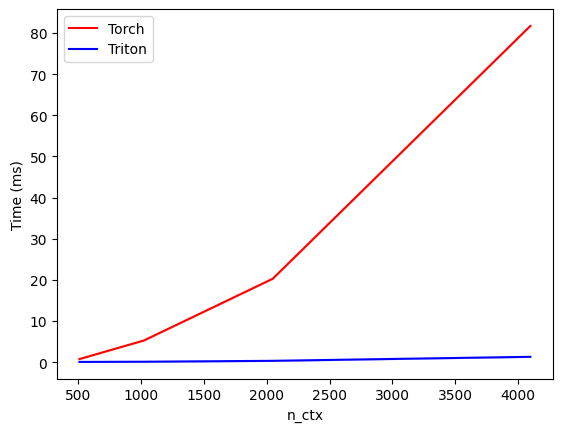

FA2 Benchmark:
    n_ctx      Torch    Triton
0   512.0   0.758193  0.060559
1  1024.0   5.267590  0.108047
2  2048.0  20.270592  0.327330
3  4096.0  81.714172  1.303893


In [3]:
import torch
import triton
import triton.language as tl
import triton.testing
DEVICE = "cuda"

@triton.jit
# Block-wise attention forward with explicit diagonal flag
def attention_forward_block(acc, l_i, m_i, q,  \
                            K_block_ptr, V_block_ptr,  \
                            start_m, qk_scale,  \
                            BLOCK_M: tl.constexpr, HEAD_DIM: tl.constexpr, BLOCK_N: tl.constexpr,  \
                            ON_DIAGONAL: tl.constexpr, offs_m: tl.constexpr, offs_n: tl.constexpr,  \
                            SEQ_LEN: tl.constexpr, use_fp8: tl.constexpr):
    # determine block range: off-diagonal vs diagonal
    if not ON_DIAGONAL:
        lo, hi = 0, start_m * BLOCK_M
    else:
        lo, hi = start_m * BLOCK_M, (start_m + 1) * BLOCK_M
        lo = tl.multiple_of(lo, BLOCK_M)

    K_block_ptr = tl.advance(K_block_ptr, (0, lo))
    V_block_ptr = tl.advance(V_block_ptr, (lo, 0))
    # need this to be sequential, so no race condition.
    for start_n in range(lo, hi, BLOCK_N):
        start_n = tl.multiple_of(start_n, BLOCK_N)
        k = tl.load(K_block_ptr)
        qk = tl.dot(q, k)
        if ON_DIAGONAL:
            mask = offs_m[:, None] >= (start_n + offs_n[None, :])
            qk = qk * qk_scale + tl.where(mask, 0, -1.0e6)
            m_ij = tl.maximum(m_i, tl.max(qk, 1))
            qk -= m_ij[:, None]
        else:
            m_ij = tl.maximum(m_i, tl.max(qk, 1) * qk_scale)
            qk = qk * qk_scale - m_ij[:, None]
        p = tl.math.exp2(qk)
        l_ij = tl.sum(p, 1)
        alpha = tl.math.exp2(m_i - m_ij)
        l_i = l_i * alpha + l_ij
        acc = acc * alpha[:, None]

        v = tl.load(V_block_ptr)
        if use_fp8:
            p = p.to(tl.float8e5)
        else:
            p = p.to(tl.float16)
        acc = tl.dot(p, v, acc)

        m_i = m_ij
        V_block_ptr = tl.advance(V_block_ptr, (BLOCK_N, 0))
        K_block_ptr = tl.advance(K_block_ptr, (0, BLOCK_N))
    return acc, l_i, m_i

@triton.jit
def attention_forward(Q, K, V, sm_scale, M, Out,  \
                      stride_qz, stride_qh, stride_qm, stride_qk,  \
                      stride_kz, stride_kh, stride_kn, stride_kk,  \
                      stride_vz, stride_vh, stride_vk, stride_vn,  \
                      stride_oz, stride_oh, stride_om, stride_on,  \
                      BATCH_SIZE, NUM_HEADS, SEQ_LEN,  \
                      HEAD_DIM: tl.constexpr,  \
                      BLOCK_M: tl.constexpr,  \
                      BLOCK_N: tl.constexpr):
    tl.static_assert(BLOCK_N <= HEAD_DIM)
    start_m = tl.program_id(0)
    off_hz = tl.program_id(1)
    batch_id = off_hz // NUM_HEADS
    head_id = off_hz % NUM_HEADS
    qvk_offset = batch_id.to(tl.int64) * stride_qz + head_id.to(tl.int64) * stride_qh

    Q_block_ptr = tl.make_block_ptr(
        base=Q + qvk_offset,
        shape=(SEQ_LEN, HEAD_DIM),
        strides=(stride_qm, stride_qk),
        offsets=(start_m * BLOCK_M, 0),
        block_shape=(BLOCK_M, HEAD_DIM),
        order=(1, 0),
    )
    v_order: tl.constexpr = (0, 1) if V.dtype.element_ty == tl.float8e5 else (1, 0)
    V_block_ptr = tl.make_block_ptr(
        base=V + qvk_offset,
        shape=(SEQ_LEN, HEAD_DIM),
        strides=(stride_vk, stride_vn),
        offsets=(0, 0),
        block_shape=(BLOCK_N, HEAD_DIM),
        order=v_order,
    )
    K_block_ptr = tl.make_block_ptr(
        base=K + qvk_offset,
        shape=(HEAD_DIM, SEQ_LEN),
        strides=(stride_kk, stride_kn),
        offsets=(0, 0),
        block_shape=(HEAD_DIM, BLOCK_N),
        order=(0, 1),
    )
    O_block_ptr = tl.make_block_ptr(
        base=Out + qvk_offset,
        shape=(SEQ_LEN, HEAD_DIM),
        strides=(stride_om, stride_on),
        offsets=(start_m * BLOCK_M, 0),
        block_shape=(BLOCK_M, HEAD_DIM),
        order=(1, 0),
    )
    offs_m = start_m * BLOCK_M + tl.arange(0, BLOCK_M)
    offs_n = tl.arange(0, BLOCK_N)
    m_i = tl.zeros([BLOCK_M], dtype=tl.float32) - float("inf")
    l_i = tl.zeros([BLOCK_M], dtype=tl.float32) + 1.0
    acc = tl.zeros([BLOCK_M, HEAD_DIM], dtype=tl.float32)
    qk_scale = sm_scale
    qk_scale *= 1.44269504
    q = tl.load(Q_block_ptr)
    # process off-diagonal blocks
    acc, l_i, m_i = attention_forward_block(acc, l_i, m_i, q,
                                            K_block_ptr, V_block_ptr,
                                            start_m, qk_scale,
                                            BLOCK_M, HEAD_DIM, BLOCK_N,
                                            False, offs_m, offs_n, SEQ_LEN,
                                            V.dtype.element_ty == tl.float8e5)
    # process diagonal block
    acc, l_i, m_i = attention_forward_block(acc, l_i, m_i, q,
                                            K_block_ptr, V_block_ptr,
                                            start_m, qk_scale,
                                            BLOCK_M, HEAD_DIM, BLOCK_N,
                                            True, offs_m, offs_n, SEQ_LEN,
                                            V.dtype.element_ty == tl.float8e5)
    m_i += tl.math.log2(l_i)
    acc = acc / l_i[:, None]
    m_ptrs = M + off_hz * SEQ_LEN + offs_m
    tl.store(m_ptrs, m_i)
    tl.store(O_block_ptr, acc.to(Out.type.element_ty))

@triton.jit
def _attn_bwd_dkdv(dk, dv, Q, k, v, sm_scale, O, DO, M, stride_tok, stride_d, H, N_CTX, \
                   BLOCK_M1: tl.constexpr, BLOCK_N1: tl.constexpr, HEAD_DIM: tl.constexpr, \
                   start_n, start_m, num_steps, MASK: tl.constexpr):
    offs_m = start_m + tl.arange(0, BLOCK_M1)
    offs_n = start_n + tl.arange(0, BLOCK_N1)
    offs_k = tl.arange(0, HEAD_DIM)
    qT_ptrs = Q + offs_m[None, :] * stride_tok + offs_k[:, None] * stride_d
    do_ptrs = DO + offs_m[:, None] * stride_tok + offs_k[None, :] * stride_d
    o_ptrs  =  O + offs_m[:, None] * stride_tok + offs_k[None, :] * stride_d
    tl.static_assert(BLOCK_N1 % BLOCK_M1 == 0)
    curr_m = start_m
    step_m = BLOCK_M1
    for blk_idx in range(num_steps):
        qT = tl.load(qT_ptrs)
        offs_m = curr_m + tl.arange(0, BLOCK_M1)
        m = tl.load(M + offs_m)
        qkT = tl.dot(k, qT)
        pT = tl.math.exp2(qkT - m[None, :])
        if MASK:
            mask = (offs_m[None, :] >= offs_n[:, None])
            pT = tl.where(mask, pT, 0.0)
        do = tl.load(do_ptrs)
        o  = tl.load(o_ptrs)
        delta = tl.sum(o * do, axis=1)
        ppT = pT.to(tl.float16)
        dv += tl.dot(ppT, do)
        dpT = tl.dot(v, tl.trans(do)).to(tl.float32)
        dsT = pT * (dpT - delta[None, :])
        dsT = dsT.to(tl.float16)
        dk += tl.dot(dsT, tl.trans(qT))
        curr_m += step_m
        qT_ptrs += step_m * stride_tok
        do_ptrs += step_m * stride_tok
        o_ptrs  += step_m * stride_tok
    return dk, dv

@triton.jit
def _attn_bwd_dq(dq, q, K, V, O, do, m, stride_tok, stride_d, H, N_CTX, \
                 BLOCK_M2: tl.constexpr, BLOCK_N2: tl.constexpr, HEAD_DIM: tl.constexpr, \
                 start_m, start_n, num_steps, MASK: tl.constexpr):
    offs_m = start_m + tl.arange(0, BLOCK_M2)
    offs_n = start_n + tl.arange(0, BLOCK_N2)
    offs_k = tl.arange(0, HEAD_DIM)
    kT_ptrs = K + offs_n[None, :] * stride_tok + offs_k[:, None] * stride_d
    vT_ptrs = V + offs_n[None, :] * stride_tok + offs_k[:, None] * stride_d
    o   = tl.load(O + offs_m[:, None] * stride_tok + offs_k[None, :] * stride_d)
    delta = tl.sum(o * do, axis=1)
    tl.static_assert(BLOCK_M2 % BLOCK_N2 == 0)
    curr_n = start_n
    step_n = BLOCK_N2
    for blk_idx in range(num_steps):
        kT = tl.load(kT_ptrs)
        vT = tl.load(vT_ptrs)
        qk = tl.dot(q, kT)
        p = tl.math.exp2(qk - m)
        if MASK:
            offs_n_current = curr_n + tl.arange(0, BLOCK_N2)
            mask = (offs_m[:, None] >= offs_n_current[None, :])
            p = tl.where(mask, p, 0.0)
        dp = tl.dot(do, vT).to(tl.float32)
        ds = p * (dp - delta[:, None])
        ds = ds.to(tl.float16)
        dq += tl.dot(ds, tl.trans(kT))
        curr_n += step_n
        kT_ptrs += step_n * stride_tok
        vT_ptrs += step_n * stride_tok
    return dq

@triton.jit
def _attn_bwd(Q, K, V, sm_scale,  \
              O, DO,  \
              DQ, DK, DV,  \
              M,  
              stride_z, stride_h, stride_tok, stride_d,  \
              H, N_CTX,  \
              BLOCK_M1: tl.constexpr,  \
              BLOCK_N1: tl.constexpr,  \
              BLOCK_M2: tl.constexpr,  \
              BLOCK_N2: tl.constexpr,  \
              BLK_SLICE_FACTOR: tl.constexpr,  \
              HEAD_DIM: tl.constexpr):
    LN2: tl.constexpr = 0.6931471824645996
    bhid = tl.program_id(2)
    off_chz = (bhid * N_CTX).to(tl.int64)
    adj = (stride_h * (bhid % H) + stride_z * (bhid // H)).to(tl.int64)
    pid = tl.program_id(0)
    Q += adj
    K += adj
    V += adj
    O += adj
    DO += adj
    DQ += adj
    DK += adj
    DV += adj
    M += off_chz
    offs_k = tl.arange(0, HEAD_DIM)
    start_n = pid * BLOCK_N1
    start_m = start_n
    MASK_BLOCK_M1: tl.constexpr = BLOCK_M1 // BLK_SLICE_FACTOR
    offs_n = start_n + tl.arange(0, BLOCK_N1)
    dv = tl.zeros([BLOCK_N1, HEAD_DIM], dtype=tl.float32)
    dk = tl.zeros([BLOCK_N1, HEAD_DIM], dtype=tl.float32)
    k = tl.load(K + offs_n[:, None] * stride_tok + offs_k[None, :] * stride_d)
    v = tl.load(V + offs_n[:, None] * stride_tok + offs_k[None, :] * stride_d)
    num_steps = BLOCK_N1 // MASK_BLOCK_M1
    dk, dv = _attn_bwd_dkdv(dk, dv, Q, k, v, sm_scale, O, DO, M, \
                            stride_tok, stride_d, H, N_CTX, \
                            MASK_BLOCK_M1, BLOCK_N1, HEAD_DIM, \
                            start_n, start_m, num_steps, MASK=True)
    start_m += num_steps * MASK_BLOCK_M1
    num_steps = (N_CTX - start_m) // BLOCK_M1
    dk, dv = _attn_bwd_dkdv(dk, dv, Q, k, v, sm_scale, O, DO, M, \
                            stride_tok, stride_d, H, N_CTX, \
                            BLOCK_M1, BLOCK_N1, HEAD_DIM, \
                            start_n, start_m, num_steps, MASK=False)
    dv_ptrs = DV + offs_n[:, None] * stride_tok + offs_k[None, :] * stride_d
    tl.store(dv_ptrs, dv)
    dk *= sm_scale
    dk_ptrs = DK + offs_n[:, None] * stride_tok + offs_k[None, :] * stride_d
    tl.store(dk_ptrs, dk)
    start_m = pid * BLOCK_M2
    end_n = start_m + BLOCK_M2
    MASK_BLOCK_N2: tl.constexpr = BLOCK_N2 // BLK_SLICE_FACTOR
    offs_m = start_m + tl.arange(0, BLOCK_M2)
    q = tl.load(Q + offs_m[:, None] * stride_tok + offs_k[None, :] * stride_d)
    dq = tl.zeros([BLOCK_M2, HEAD_DIM], dtype=tl.float32)
    do = tl.load(DO + offs_m[:, None] * stride_tok + offs_k[None, :] * stride_d)
    m = tl.load(M + offs_m)
    m = m[:, None]
    num_steps = BLOCK_M2 // MASK_BLOCK_N2
    dq = _attn_bwd_dq(dq, q, K, V, O, do, m, \
                      stride_tok, stride_d, H, N_CTX, \
                      BLOCK_M2, MASK_BLOCK_N2, HEAD_DIM, \
                      start_m, end_n - num_steps * MASK_BLOCK_N2, num_steps, MASK=True)
    end_n -= num_steps * MASK_BLOCK_N2
    num_steps = end_n // BLOCK_N2
    dq = _attn_bwd_dq(dq, q, K, V, O, do, m, \
                      stride_tok, stride_d, H, N_CTX, \
                      BLOCK_M2, BLOCK_N2, HEAD_DIM, \
                      start_m, end_n - num_steps * BLOCK_N2, num_steps, MASK=False)
    dq_ptrs = DQ + offs_m[:, None] * stride_tok + offs_k[None, :] * stride_d
    dq *= LN2
    tl.store(dq_ptrs, dq)

class _attention(torch.autograd.Function):
    @staticmethod
    def forward(ctx, q, k, v, sm_scale, warp_specialize=True, USE_TMA=True):
        HEAD_DIM_Q, HEAD_DIM_K = q.shape[-1], k.shape[-1]
        HEAD_DIM_V = v.shape[-1]
        assert HEAD_DIM_Q == HEAD_DIM_K and HEAD_DIM_K == HEAD_DIM_V
        assert HEAD_DIM_K in {16, 32, 64, 128, 256}
        o = torch.empty_like(q)
        M = torch.empty((q.shape[0], q.shape[1], q.shape[2]), device=q.device, dtype=torch.float32)
        grid = lambda args: (triton.cdiv(q.shape[2], args["BLOCK_M"]), q.shape[0] * q.shape[1], 1)
        ctx.grid = grid
        attention_forward[grid](
            q, k, v, sm_scale, M, o,  \
            q.stride(0), q.stride(1), q.stride(2), q.stride(3),  \
            k.stride(0), k.stride(1), k.stride(2), k.stride(3),  \
            v.stride(0), v.stride(1), v.stride(2), v.stride(3),  \
            o.stride(0), o.stride(1), o.stride(2), o.stride(3),  \
            q.shape[0], q.shape[1], q.shape[2],  \
            BLOCK_M=64,  \
            BLOCK_N=32,  \
            HEAD_DIM=HEAD_DIM_K)
        ctx.save_for_backward(q, k, v, o, M)
        ctx.sm_scale = sm_scale
        ctx.HEAD_DIM = HEAD_DIM_K
        return o

    @staticmethod
    def backward(ctx, do):
        q, k, v, o, M = ctx.saved_tensors
        assert do.is_contiguous()
        assert q.stride() == k.stride() == v.stride() == o.stride() == do.stride()
        dq = torch.empty_like(q)
        dk = torch.empty_like(k)
        dv = torch.empty_like(v)
        BATCH, N_HEAD, N_CTX = q.shape[:3]
        BLOCK_M1, BLOCK_N1, BLOCK_M2, BLOCK_N2 = 32, 64, 64, 32 # dKdV Q-seqlength-block, dKdV KV-seqlength-block, dQ Q-seqlength-block, dQ KV-seqlength-block.
        BLK_SLICE_FACTOR = 2
        RCP_LN2 = 1.4426950408889634
        arg_k = k * (ctx.sm_scale * RCP_LN2)
        PRE_BLOCK = 64
        assert N_CTX % PRE_BLOCK == 0
        pre_grid = (N_CTX // PRE_BLOCK, BATCH * N_HEAD)
        grid = (N_CTX // BLOCK_N1, 1, BATCH * N_HEAD)
        _attn_bwd[grid](
            q, arg_k, v, ctx.sm_scale, o, do, dq, dk, dv,  \
            M,  \
            q.stride(0), q.stride(1), q.stride(2), q.stride(3),  \
            N_HEAD, N_CTX,  \
            BLOCK_M1=BLOCK_M1, BLOCK_N1=BLOCK_N1,  \
            BLOCK_M2=BLOCK_M2, BLOCK_N2=BLOCK_N2,  \
            BLK_SLICE_FACTOR=BLK_SLICE_FACTOR,  \
            HEAD_DIM=ctx.HEAD_DIM)
        return dq, dk, dv, None, None, None, None

attention = _attention.apply

def test_forward():
    batch_size = 8
    n_heads = 16
    n_ctx = 1024
    head_dim = 64
    sm_scale = 0.5

    q = torch.randn((batch_size, n_heads, n_ctx, head_dim), dtype=torch.float16, device=DEVICE, requires_grad=True)
    k = torch.randn((batch_size, n_heads, n_ctx, head_dim), dtype=torch.float16, device=DEVICE, requires_grad=True)
    v = torch.randn((batch_size, n_heads, n_ctx, head_dim), dtype=torch.float16, device=DEVICE, requires_grad=True)

    p = torch.matmul(q, k.transpose(-2, -1)) * sm_scale
    tril = torch.tril(torch.ones((n_ctx, n_ctx), device=DEVICE))
    p = p.masked_fill(tril == 0, float("-inf"))
    p = torch.softmax(p.float(), dim=-1).half()
    ref_out = torch.matmul(p, v)

    attn_out = attention(q, k, v, sm_scale)

    close_elements = torch.isclose(ref_out, attn_out, atol=0.01, rtol=0).sum().item()
    total_elements = ref_out.numel()
    percentage_correct = (close_elements / total_elements) * 100
    print(f"Forward test: {percentage_correct:.2f}% of elements are within 0.01 (atol) of PyTorch output.")
    assert percentage_correct >= 99.0, f"Forward test failed: {percentage_correct:.2f}% elements close, expected 99%"
    print("Forward test passed.")

def test_backward():
    batch_size = 8
    n_heads = 16
    n_ctx = 1024
    head_dim = 64
    sm_scale = 0.5

    q = torch.randn((batch_size, n_heads, n_ctx, head_dim), dtype=torch.float16, device=DEVICE, requires_grad=True)
    k = torch.randn((batch_size, n_heads, n_ctx, head_dim), dtype=torch.float16, device=DEVICE, requires_grad=True)
    v = torch.randn((batch_size, n_heads, n_ctx, head_dim), dtype=torch.float16, device=DEVICE, requires_grad=True)

    p = torch.matmul(q, k.transpose(-2, -1)) * sm_scale
    tril = torch.tril(torch.ones((n_ctx, n_ctx), device=DEVICE))
    p = p.masked_fill(tril == 0, float("-inf"))
    p = torch.softmax(p.float(), dim=-1).half()
    ref_out = torch.matmul(p, v)
    dout = torch.randn_like(ref_out)
    ref_out.backward(dout)
    ref_dq = q.grad.clone()
    ref_dk = k.grad.clone()
    ref_dv = v.grad.clone()

    q.grad = None
    k.grad = None
    v.grad = None

    attn_out = attention(q, k, v, sm_scale)
    attn_out.backward(dout)
    tri_dq = q.grad.clone()
    tri_dk = k.grad.clone()
    tri_dv = v.grad.clone()

    close_elements_dq = torch.isclose(ref_dq, tri_dq, atol=0.01, rtol=0).sum().item()
    total_elements_dq = ref_dq.numel()
    percentage_correct_dq = (close_elements_dq / total_elements_dq) * 100
    print(f"Backward test (dQ): {percentage_correct_dq:.2f}% of elements are within 0.01 (atol) of PyTorch output.")
    assert percentage_correct_dq >= 99.0, f"Backward test (dQ) failed: {percentage_correct_dq:.2f}% elements close, expected 99%"

    close_elements_dk = torch.isclose(ref_dk, tri_dk, atol=0.01, rtol=0).sum().item()
    total_elements_dk = ref_dk.numel()
    percentage_correct_dk = (close_elements_dk / total_elements_dk) * 100
    print(f"Backward test (dK): {percentage_correct_dk:.2f}% of elements are within 0.01 (atol) of PyTorch output.")
    assert percentage_correct_dk >= 99.0, f"Backward test (dK) failed: {percentage_correct_dk:.2f}% elements close, expected 99%"

    close_elements_dv = torch.isclose(ref_dv, tri_dv, atol=0.01, rtol=0).sum().item()
    total_elements_dv = ref_dv.numel()
    percentage_correct_dv = (close_elements_dv / total_elements_dv) * 100
    print(f"Backward test (dV): {percentage_correct_dv:.2f}% of elements are within 0.01 (atol) of PyTorch output.")
    assert percentage_correct_dv >= 99.0, f"Backward test (dV) failed: {percentage_correct_dv:.2f}% elements close, expected 99%"
    
    print("Backward test passed.")

if __name__ == "__main__":
    test_forward()
    test_backward()
    # memory and speed benchmark
    def measure_time_and_memory(fn, device):
        torch.cuda.reset_peak_memory_stats(device)
        torch.cuda.synchronize(device)
        ms = triton.testing.do_bench(fn)
        torch.cuda.synchronize(device)
        peak = torch.cuda.max_memory_allocated(device)
        return ms, peak

    # setup parameters for benchmarks
    batch_size, n_heads, n_ctx, head_dim = 1, 32, 2048, 64
    device = torch.device(DEVICE)
    sm_scale = 0.5
    q = torch.randn((batch_size, n_heads, n_ctx, head_dim), dtype=torch.float16, device=device, requires_grad=True)
    k = torch.randn_like(q)
    v = torch.randn_like(q)

    def run_torch_forward():
        p = torch.matmul(q, k.transpose(-2, -1)) * sm_scale
        tril = torch.tril(torch.ones((n_ctx, n_ctx), device=device))
        p = p.masked_fill(tril == 0, float("-inf"))
        p = torch.softmax(p.float(), dim=-1).half()
        return torch.matmul(p, v)

    def run_triton_forward():
        return attention(q, k, v, sm_scale)

    ms_torch, peak_torch = measure_time_and_memory(run_torch_forward, device)
    ms_triton, peak_triton = measure_time_and_memory(run_triton_forward, device)
    print(f"Torch forward time: {ms_torch:.2f} ms   peak mem: {peak_torch/1024**2:.1f} MB")
    print(f"Triton forward time: {ms_triton:.2f} ms   peak mem: {peak_triton/1024**2:.1f} MB")

    # benchmark backward
    def run_torch_backward():
        q.grad, k.grad, v.grad = None, None, None
        out = run_torch_forward()
        grad = torch.randn_like(out)
        out.backward(grad)

    def run_triton_backward():
        q.grad, k.grad, v.grad = None, None, None
        out = run_triton_forward()
        grad = torch.randn_like(out)
        out.backward(grad)

    ms_torch_bwd, peak_torch_bwd = measure_time_and_memory(run_torch_backward, device)
    ms_triton_bwd, peak_triton_bwd = measure_time_and_memory(run_triton_backward, device)
    print(f"Torch backward time: {ms_torch_bwd:.2f} ms   peak mem: {peak_torch_bwd/1024**2:.1f} MB")
    print(f"Triton backward time: {ms_triton_bwd:.2f} ms   peak mem: {peak_triton_bwd/1024**2:.1f} MB")

    # Performance plots using Triton perf_report
    configs = [
        triton.testing.Benchmark(
            x_names=["n_ctx"], x_vals=[512, 1024, 2048, 4096],
            line_arg="provider", line_vals=["Torch", "Triton"],
            line_names=["Torch", "Triton"], styles=[("red","-"),("blue","-")],
            ylabel="Time (ms)", plot_name="FA2 Benchmark",
            args={"batch_size": batch_size, "n_heads": n_heads, "head_dim": head_dim, "sm_scale": sm_scale},
        )
    ]
    @triton.testing.perf_report(configs)
    def benchmark(n_ctx, provider, batch_size, n_heads, head_dim, sm_scale):
        device = torch.device(DEVICE)
        q = torch.randn((batch_size, n_heads, n_ctx, head_dim), dtype=torch.float16, device=device)
        k = torch.randn_like(q)
        v = torch.randn_like(q)
        def run_torch_forward():
            p = torch.matmul(q, k.transpose(-2, -1)) * sm_scale
            tril = torch.tril(torch.ones((n_ctx, n_ctx), device=device))
            p = p.masked_fill(tril == 0, float("-inf"))
            p = torch.softmax(p.float(), dim=-1).half()
            return torch.matmul(p, v)
        def run_triton_forward():
            return attention(q, k, v, sm_scale)
        if provider == "Torch":
            result = triton.testing.do_bench(run_torch_forward)
        else:
            result = triton.testing.do_bench(run_triton_forward)
        if isinstance(result, tuple):
            ms, min_ms, max_ms = result
        else:
            ms = min_ms = max_ms = result
        return ms, min_ms, max_ms

    benchmark.run(show_plots=True, print_data=True)